This notebook runs a defined pipeline on HCP subjects, on the Cedars-Sinai cluster.
After it is done preprocessing all subjects, it runs the leave-one-out IQ prediction a la Finn.

# Load libraries & helper functions

In [1]:
from helpers import *
%matplotlib inline

# Declare parameters

In [2]:
config.DATADIR      = '/scratch/duboisjx/data/HCP/MRI'

# fMRI runs
fmriRuns      = ['rfMRI_REST1_LR','rfMRI_REST1_RL']

# use volume or surface data
config.isCifti      = False
config.overwrite    = False

config.pipelineName = 'Ciric9'
# use ICA-FIX input
config.useFIX       = False
config.preWhitening = False
config.Operations   = config.operationDict[config.pipelineName]

config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'

# whether to use memmapping (which involves unzipping)
config.useMemMap    = False

# parcellation for FC matrix
config.parcellationName = 'shen2013'
config.parcellationFile = '/scratch/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_2mm_268_parcellation.nii.gz'
config.nParcels         = 268
# config.parcellationName   = 'HO110_25'
# config.parcellationFile   = '/scratch/duboisjx/data/parcellations/HarvardOxford/HO110/HarvardOxford-cort+sub-maxprob-thr25-2mm.nii.gz'
# config.nParcels           = 110
config.maskParcelswithAll = True
config.maskParcelswithGM  = False
if config.maskParcelswithGM:
    config.parcellationName = config.parcellationName + '_GM'

# subject selection parameters
#config.behavFile = '/home/duboisjx/mnt10/LabUsers/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
config.behavFile = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
config.release   = 'Q2'
config.outScore  = 'PMAT24_A_CR'

# Subject selection

Selected 123 from the release Q2
Number of males is: 40
Age range is 22 - 35
114924 : too much motion, exclude
123117 : too much motion, exclude
151223 : too much motion, exclude
156637 : too much motion, exclude
191437 : too much motion, exclude
199150 : too much motion, exclude
250427 : too much motion, exclude
298051 : too much motion, exclude
788876 : too much motion, exclude
937160 : too much motion, exclude


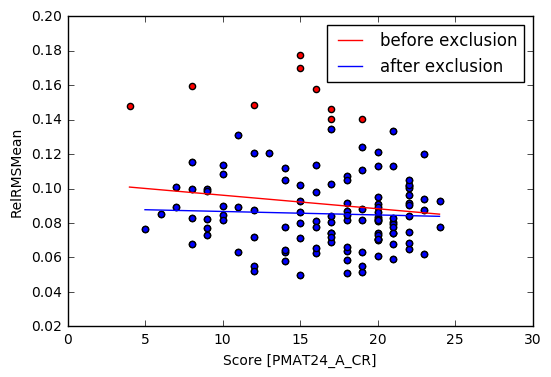

With all subjects: corr(IQ,motion) = -0.140 (p = 0.122)
After discarding high movers: corr(IQ,motion) = -0.050 (p = 0.600)
Keeping 113 subjects [36 M]


In [ ]:
df = pd.read_csv(config.behavFile)
# select subjects according to release
if config.release == 'Q2':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    ind = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    ind = (df['Release'] == 'S900')
elif config.release == 'S1200':
    ind = (df['Release'] == 'S1200')
elif config.release == 'all':
    ind = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
else:
    sys.exit("Invalid release code")
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_PctCompl']==100) & (df['fMRI_Mot_PctCompl']==100) 
             & (df['fMRI_Lang_PctCompl']==100) & (df['fMRI_Emo_PctCompl']==100)         
             & (df['3T_RS-fMRI_PctCompl']==100) & (df['PMAT_Compl']==True))
df = df[ind]  
# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
tmpAgeRanges = sorted(df['Age'].unique())
# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[config.outScore]

print 'Selected', str(df.shape[0]), 'from the release',config.release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
subjects   = [str(subject) for subject in subjects]
RelRMSMean = np.zeros([len(subjects), len(fmriRuns)],dtype=np.float32)
compSub    = np.zeros((len(subjects)),dtype=np.bool_)
keepSub    = np.zeros((len(subjects)),dtype=np.bool_)
iSub=0
for config.subject in subjects:
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        #print RelRMSMeanFile
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        compSub[iSub]=True
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print config.subject, ': too much motion, exclude'
        else:
            keepSub[iSub]=True
    iSub=iSub+1

#### motion vs. score correlation
plt.scatter(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),c='r')
plt.scatter(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),c='b')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),1)
z2 = np.polyfit(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[keepSub])
fit2 = p2(score[compSub])
# get the coordinates for the fit curve
c1_x = [np.min(score[keepSub]),np.max(score[keepSub])]
c1_y = p1(c1_x)
c2_x = [np.min(score[compSub]),np.max(score[compSub])]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.xlabel('Score [{}]'.format(config.outScore))
plt.ylabel('RelRMSMean')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1))
rho2,p2 = stats.pearsonr(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1))            
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)
    
subjects   = [subject for (subject, keep) in zip(subjects, keepSub) if keep]
age        = age[keepSub]
gender     = gender[keepSub]
score      = score[keepSub]
RelRMSMean = RelRMSMean[keepSub,:]
print 'Keeping {} subjects [{} M]'.format(len(subjects),sum([g=='M' for g in gender]))

# Do work

### preprocess everybody

In [ ]:
# submit jobs with sge
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 

keepSub = np.zeros((len(subjects)),dtype=np.bool_)
iSub=0
for config.subject in subjects:
    iRun = 0
    for config.fmriRun in fmriRuns:
        #print 'SUB {}/{} [{}]: run {}/{} [{}]'.format(iSub+1,len(subjects),config.subject,iRun+1,len(fmriRuns),config.fmriRun)
        keepSub[iSub] = runPipelinePar(launchSubproc=False)
        if not keepSub[iSub]:
            break
        iRun=iRun+1
    iSub = iSub + 1
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(subjects))

subjects = [subject for (iSub,subject) in enumerate(subjects) if keepSub[iSub]]
checkProgress()

submitted s100307_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483131)
submitted s100307_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483132)
submitted s103414_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483133)
submitted s103414_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483134)
submitted s103515_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483135)
submitted s103515_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483136)
submitted s103818_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483137)
submitted s103818_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483138)
submitted s105115_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483139)
submitted s105115_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483140)
submitted s110411_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483141)
submitted s110411_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483142)
submitted s111312_rfMRI_REST1_LR_Ciric9_ciftiFalse (SGE job #483143)
submitted s111312_rfMRI_REST1_RL_Ciric9_ciftiFalse (SGE job #483144)
submitted s113619_rfMRI_REST1_LR_C

## Save all FC matrices in a file

In [ ]:
config.queue        = False

print 'Saving all FC matrices in a .mat file...'
fcMatFile =  op.join(config.DATADIR,'fcMats_{}_{}.mat'.format(config.pipelineName, config.parcellationName))
fcMats_dn = np.zeros((config.nParcels,config.nParcels,len(subjects),len(fmriRuns)),dtype=np.float32)
iSub= 0
for config.subject in subjects:
    iRun = 0
    for config.fmriRun in fmriRuns:
        # set the global variable config
        runPipelinePar(launchSubproc=False)
        tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
        rstring = get_rcode(config.fmriFile_dn)
        fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
        if not op.isfile(fcFile_dn): 
            computeFC(overwrite=True)
        fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
        iRun = iRun+1
    iSub = iSub + 1

fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
results = {}
results['fcMats'] = fcMats_dn
results['subjects']      = subjects
results[config.outScore] = np.asarray(score)
sio.savemat(fcMatFile, results)

## IQ prediction

In [ ]:
# submit jobs with sge
config.queue        = True
config.sgeopts      = '-l mem_free=2G' 

# run the IQ prediction for each subject
runPredictionPar(fcMatFile,thresh=0.01)
checkProgress()

In [ ]:
# merge cross-validation folds, save results
n_subs          = fcMats_dn.shape[-1]
predictions_pos = np.zeros([n_subs,1])
predictions_neg = np.zeros([n_subs,1])
iSub = 0
for subject in subjects:
   results = sio.loadmat(op.join(config.DATADIR, 'IQpred_{}_{}_{}.mat'.format(config.pipelineName, config.parcellationName, subject))) 
   predictions_pos[iSub] = results['pred_pos']
   predictions_neg[iSub] = results['pred_neg']
   iSub = iSub + 1
rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(score)))
results = {'pred_pos':predictions_pos, 'pred_neg':predictions_neg, 'rho':rho, 'p': p}
# save result
sio.savemat(op.join(config.DATADIR, 'IQpred_{}_{}.mat'.format(config.pipelineName, config.parcellationName)),results)
print 'Correlation score: rho {} p {}'.format(rho,p)

In [ ]:
# plot!
x = np.ravel(score)
# positive
fig = plt.figure(figsize=(10,20))
y = np.ravel(predictions_pos)
plot_corrs(x,y,'Using positive edges')
# negative
fig2 = plt.figure(figsize=(10,20))
y = np.ravel(predictions_neg)
plot_corrs(x,y,'Using negative edges')